# LOGISTIC REGRESSION.

This code was used to extract the results for Section 5.1. and 5.2., following the methodology and experimental description.

It includes:

1) Model training and Evaluation

2) Gender bias computation

3) Result visualization and analysis

### 1. Model Training & Evaluation

In [ ]:
import json
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.sparse import load_npz
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, Subset, DataLoader

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
with open("/content/drive/MyDrive/dedicated_WAM/data/gemma-2-2b_25-gemmascope-res-16k.json", "r") as f:
    description = json.load(f)

In [ ]:
def load_sparse(folder_path, file_name):
    big_sparse = load_npz(f"{folder_path}{file_name}.npz")
    seq_lengths = np.load(f"{folder_path}{file_name}_seq_lengths.npy", allow_pickle=True).tolist()

    result = []
    idx = 0
    for L in seq_lengths:
        prompt_feats = big_sparse[idx: idx + L, :]
        result.append(prompt_feats)
        idx += L

    return np.array([sparse.max(axis=0).toarray().flatten() for sparse in result])

In [ ]:
input_folder = "/content/drive/MyDrive/dedicated_WAM/results/Embeddings/Sparse_matrices/Prompts-25k/"

female_inputs = "female_prompts_sae_embeddings"
male_inputs = "male_prompts_sae_embeddings"

inputs = {'she': load_sparse(input_folder, female_inputs),
          'he': load_sparse(input_folder, male_inputs)}

In [ ]:
print(inputs['she'].shape)
print(inputs['he'].shape)

(25000, 16384)
(25000, 16384)


In [ ]:
def load_model(model_name):
    folder_path = f"/content/drive/MyDrive/dedicated_WAM/results/Embeddings/Sparse_matrices/{model_name}-25k/"

    female_outputs = "female_sae_embeddings"
    male_outputs = "male_sae_embeddings"

    she_act = load_sparse(folder_path, female_outputs)
    he_act = load_sparse(folder_path, male_outputs)

    return {'she': she_act, 'he': he_act}

In [ ]:
models = {
    'deepseek': load_model("DeepSeek-V3"),
    'llama': load_model("Llama"),
    'mistral': load_model("Mistral-Nemo")
}

In [ ]:
class SparseDataset(Dataset):
    def __init__(self, inputs, models):
        self.inputs = inputs
        self.models = models
        self.model_names = list(models.keys())
        self.J = len(self.model_names)
        self.N = self.inputs['she'].shape[0]
        if self.inputs['he'].shape[0] != self.N:
            raise ValueError("Both genders must have the same number of samples!")
        self.X_sae_she = csr_matrix(self.inputs['she'] > 0)
        self.X_sae_he = csr_matrix(self.inputs['he'] > 0)
        self.len_she = self.N * self.J
        self.len_he = self.N * self.J
        self.total_len = self.len_she + self.len_he

    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):

        if idx < self.len_she:
            gender = 'she'
            local_idx = idx
            model_index = local_idx // self.N
            row_idx = local_idx % self.N
            X_sae_row = self.X_sae_she[row_idx]
            female_bias = np.zeros(self.J, dtype=np.float32)
            female_bias[model_index] = 1.0
            male_bias = np.zeros(self.J, dtype=np.float32)

        else:
            gender = 'he'
            local_idx = idx - self.len_she
            model_index = local_idx // self.N
            row_idx = local_idx % self.N
            X_sae_row = self.X_sae_he[row_idx]
            female_bias = np.zeros(self.J, dtype=np.float32)
            male_bias = np.zeros(self.J, dtype=np.float32)
            male_bias[model_index] = 1.0

        bias_features = np.concatenate([female_bias, male_bias])
        X_sae_dense = X_sae_row.toarray().squeeze(0)
        features = np.concatenate([X_sae_dense, bias_features])
        X_dense = torch.tensor(features, dtype=torch.float32)
        model_name = self.model_names[model_index]
        y_data = self.models[model_name][gender][row_idx]

        if hasattr(y_data, "toarray"):
            y_bin = (y_data > 0)
            y_dense = torch.tensor(y_bin.toarray(), dtype=torch.float32).squeeze(0)

        else:
            y_bin = (np.array(y_data) > 0).astype(np.int8)
            y_dense = torch.tensor(y_bin, dtype=torch.float32)
            if y_dense.dim() == 2 and y_dense.shape[0] == 1:
                y_dense = y_dense.squeeze(0)

        return X_dense, y_dense

In [ ]:
batch_size = 64

dataset = SparseDataset(inputs, models)
train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def test_model(W, test_loader, loss_fn, device, epoch, train_losses, test_losses):
    W = W.detach()
    running_loss = 0.0
    tp = tn = fp = fn = 0

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            logits = batch_X.matmul(W.t())
            loss = loss_fn(logits, batch_y)
            running_loss += loss.item() * batch_X.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            # Flatten predictions and labels for metric computation.
            preds_flat = preds.view(-1)
            labels_flat = batch_y.view(-1)

            tp += ((preds_flat == 1) & (labels_flat == 1)).sum().item()
            tn += ((preds_flat == 0) & (labels_flat == 0)).sum().item()
            fp += ((preds_flat == 1) & (labels_flat == 0)).sum().item()
            fn += ((preds_flat == 0) & (labels_flat == 1)).sum().item()

    test_loss = running_loss / len(test_loader.dataset)
    test_losses.append(test_loss)

    total = tp + tn + fp + fn
    acc = (tp + tn) / total
    f1 = 2 * tp / (2 * tp + fp + fn)

    print(f"Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

    # Optionally clear GPU cache.
    torch.cuda.empty_cache()

    conf_matrix = np.array([[tn, fp], [fn, tp]])

    # Create a figure with two subplots side-by-side.
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))

    # Left subplot: Training vs Test Loss.
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker='o')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label="Test Loss", marker='o')
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].set_title("Training vs Test Loss")
    axs[0].legend()

    # Right subplot: Confusion Matrix.
    im = axs[1].imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    axs[1].set_title("Confusion Matrix")
    # Create tick marks and labels.
    classes = ['Negative', 'Positive']
    tick_marks = np.arange(len(classes))
    axs[1].set_xticks(tick_marks)
    axs[1].set_xticklabels(classes)
    axs[1].set_yticks(tick_marks)
    axs[1].set_yticklabels(classes)

    # Annotate the confusion matrix cells with counts.
    thresh = conf_matrix.max() / 2.0
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            # Format as millions with 2 decimal places
            if conf_matrix[i, j] >= 1000000:
                formatted_value = f"{conf_matrix[i, j]/1000000:.2f}M"
            else:
                formatted_value = f"{conf_matrix[i, j]/1000000:.2f}M"

            axs[1].text(j, i, formatted_value,
                        ha="center", va="center",
                        color="white" if conf_matrix[i, j] > thresh else "black")

    # Optionally clear GPU cache.
    torch.cuda.empty_cache()

    plt.tight_layout()
    plt.show()

    return test_loss, f1, acc

In [ ]:
def train_models(train_loader, test_loader, alpha=0.0001, epochs=10, lr=0.01):
    F = 128**2                 # SAE features
    D = F + (2 * len(models))  # Columns: [X_sae, model/gender indicator (2*J)]

    import torch
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize weights and optimizer.
    W = torch.zeros((F, D), device=device, requires_grad=True)
    optimizer = torch.optim.SGD([W], lr=lr, weight_decay=alpha)

    pos_weight = torch.tensor(3.0, device=device)
    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    train_losses, test_losses = [], []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        epoch_loss = 0.0

        # Training loop
        for batch_X, batch_y in tqdm(train_loader):
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            logits = batch_X.matmul(W.t())
            loss = loss_fn(logits, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_X.size(0)

        epoch_loss /= len(train_dataset)
        train_losses.append(epoch_loss)

        # Evaluate after each epoch.
        test_model(W, test_loader, loss_fn, device, epoch, train_losses, test_losses)

    # LogisticModel class for final predictions.
    class LogisticModel:
        def __init__(self, weight):
            self.weight = weight
        def predict(self, X_input):
            device = self.weight.device
            X_t = torch.tensor(X_input, dtype=torch.float32, device=device)
            with torch.no_grad():
                logits = X_t.matmul(self.weight.t())
                probs = torch.sigmoid(logits)
                return (probs > 0.5).cpu().numpy().ravel()

    feature_models = [LogisticModel(W[i].unsqueeze(0)) for i in range(F)]
    return feature_models

Epoch 1/10


100%|██████████| 1875/1875 [01:57<00:00, 15.97it/s]


Train Loss: 0.7052, Test Loss: 0.5934, Accuracy: 0.9292, F1 Score: 0.7214


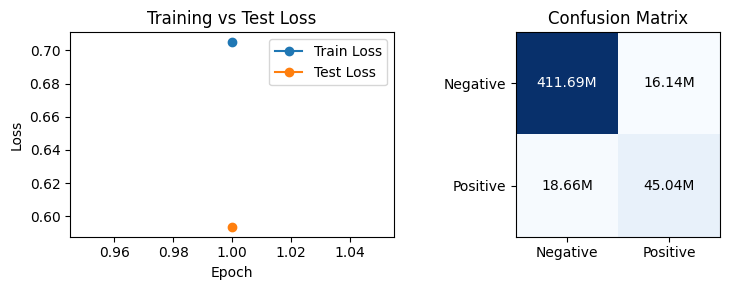

Epoch 2/10


100%|██████████| 1875/1875 [01:56<00:00, 16.11it/s]


Train Loss: 0.5352, Test Loss: 0.4905, Accuracy: 0.9293, F1 Score: 0.7216


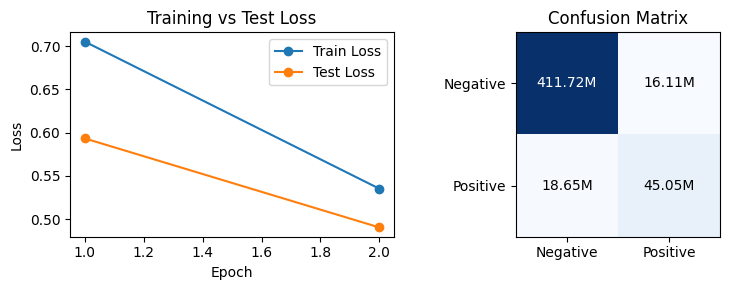

Epoch 3/10


100%|██████████| 1875/1875 [01:56<00:00, 16.06it/s]


Train Loss: 0.4624, Test Loss: 0.4396, Accuracy: 0.9294, F1 Score: 0.7219


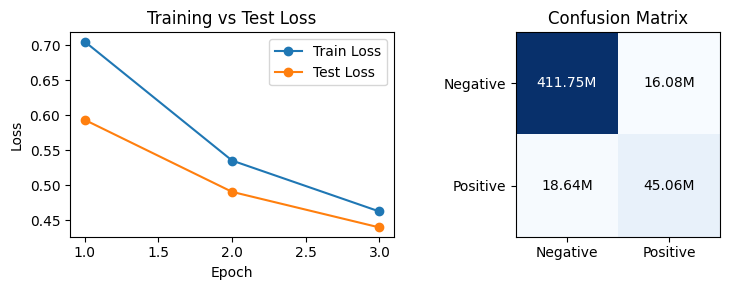

Epoch 4/10


100%|██████████| 1875/1875 [01:55<00:00, 16.18it/s]


Train Loss: 0.4239, Test Loss: 0.4106, Accuracy: 0.9295, F1 Score: 0.7223


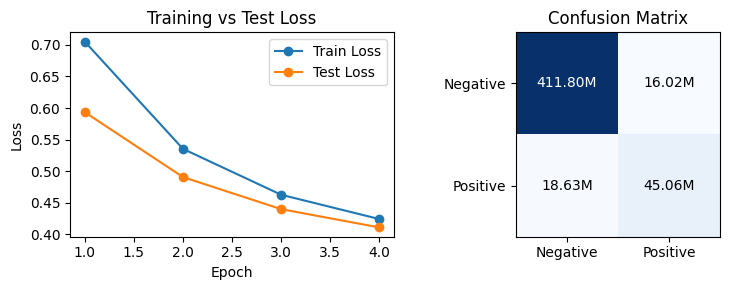

Epoch 5/10


100%|██████████| 1875/1875 [01:56<00:00, 16.12it/s]


Train Loss: 0.4009, Test Loss: 0.3925, Accuracy: 0.9296, F1 Score: 0.7227


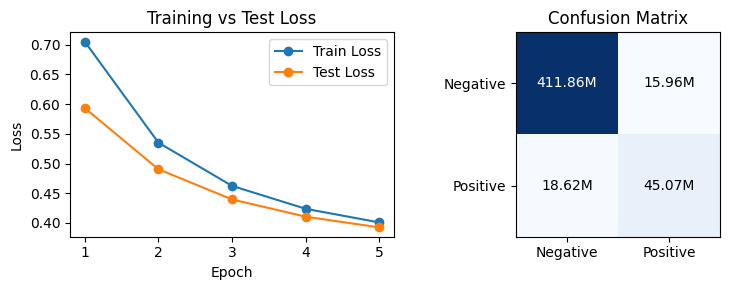

Epoch 6/10


100%|██████████| 1875/1875 [01:56<00:00, 16.06it/s]


Train Loss: 0.3860, Test Loss: 0.3804, Accuracy: 0.9298, F1 Score: 0.7232


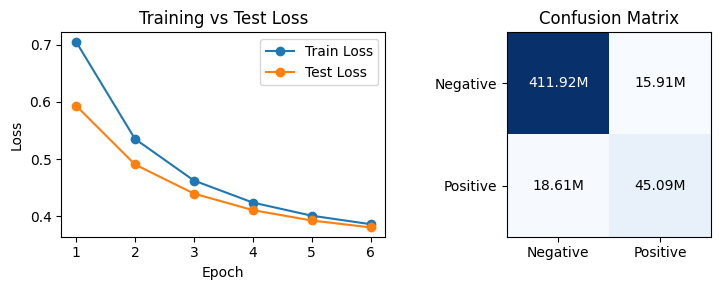

Epoch 7/10


100%|██████████| 1875/1875 [01:56<00:00, 16.07it/s]


Train Loss: 0.3758, Test Loss: 0.3718, Accuracy: 0.9299, F1 Score: 0.7237


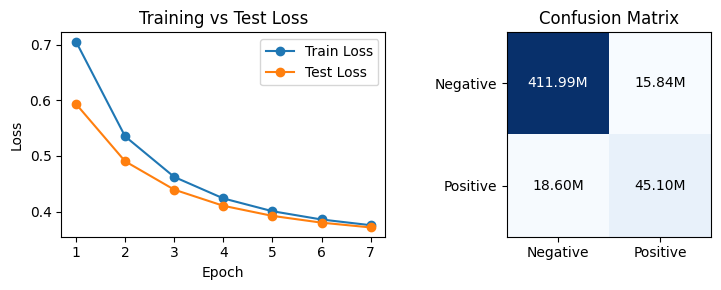

Epoch 8/10


100%|██████████| 1875/1875 [01:56<00:00, 16.04it/s]


Train Loss: 0.3684, Test Loss: 0.3655, Accuracy: 0.9301, F1 Score: 0.7242


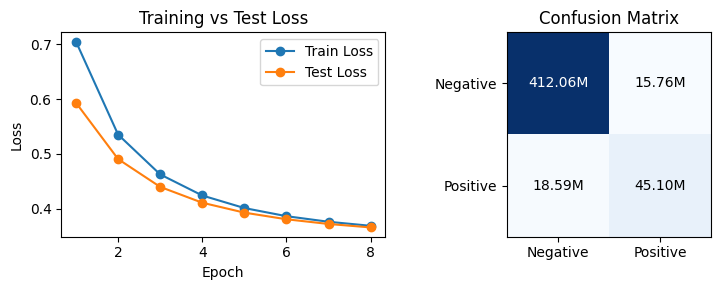

Epoch 9/10


100%|██████████| 1875/1875 [01:56<00:00, 16.04it/s]


Train Loss: 0.3629, Test Loss: 0.3606, Accuracy: 0.9303, F1 Score: 0.7247


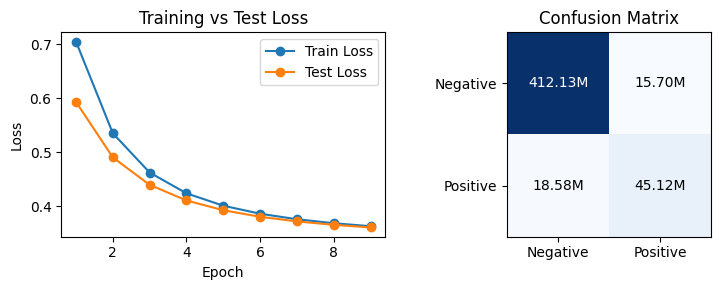

Epoch 10/10


100%|██████████| 1875/1875 [01:56<00:00, 16.05it/s]


Train Loss: 0.3586, Test Loss: 0.3568, Accuracy: 0.9304, F1 Score: 0.7252


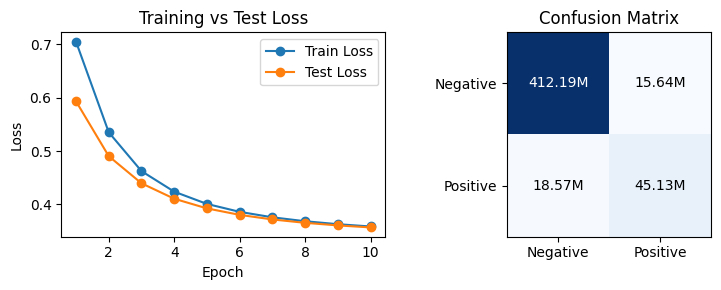

In [ ]:
feat_models = train_models(train_loader, test_loader)

#2. Bias Com

In [ ]:
def interpret_feature_models(feature_models, model_names):

    description_dict = {int(item['index']): item['description'] for item in description}

    m = len(model_names)
    divergence_dict = {mname: [] for mname in model_names}
    for fm in feature_models:
        coefs = fm.weight.cpu().detach().numpy().ravel()
        D_sae = 128**2
        female_bias = coefs[D_sae:D_sae+m]
        male_bias = coefs[D_sae+m:D_sae+2*m]
        for j, mname in enumerate(model_names):
            divergence = male_bias[j] - female_bias[j]
            divergence_dict[mname].append(divergence)

    dfs = {}
    for mname in model_names:
        df = pd.DataFrame({"Model Divergence": divergence_dict[mname]})
        #df['Description'] = df.index.astype(str).map(description)
        df['Description'] = df.index.map(lambda idx: description_dict.get(idx, "Unknown"))

        df['Rank'] = df['Model Divergence'].abs().rank(ascending=False, method="min").astype(int)
        df['Higher_activation'] = df['Model Divergence'].apply(lambda x: "he" if x > 0 else ("she" if x < 0 else "none"))
        dfs[mname] = df
    return dfs

In [ ]:
all_coeffs = []
for model in feat_models:
    all_coeffs.append(model.weight.cpu().detach().numpy().ravel())
all_coeffs = np.array(all_coeffs)

np.save("all_coeffs.npy", all_coeffs)

In [ ]:
bias = interpret_feature_models(feat_models, models.keys())

In [ ]:
def print_top_features(results, n=20):
    print(f"{'Rank':<5} {'Set':<5} {'Bias':<7} Description")
    for x, row in results.sort_values(by='Rank').reset_index().iterrows():
        if isinstance(row.Description, str):
            print(f"{row.Rank:<5} {row.Higher_activation:<5} {row['Model Divergence']*10_000:>5.0f}   {row.Description.strip()}")
        if x > n-2: break

In [ ]:
for model in models.keys():
    print(model)
    print_top_features(bias[model], n=5)
    print('=' * 100)

deepseek
Rank  Set   Bias    Description
1     she     -15   references to family planning and interpersonal relationships
2     he       13   contextually significant punctuation and formatting marks in the text
3     she     -12   references to familial relationships, particularly focusing on wives and daughters
4     she     -12   people's biographical details and achievements
5     he       11   references to financial matters or monetary contributions
llama
Rank  Set   Bias    Description
1     he       12   contextually significant punctuation and formatting marks in the text
2     she     -12   references to family planning and interpersonal relationships
3     she     -12   people's biographical details and achievements
4     she     -11   references to familial relationships, particularly focusing on wives and daughters
5     he       11   references to financial matters or monetary contributions
mistral
Rank  Set   Bias    Description
1     she     -13   references to family 

In [ ]:
df = (pd.DataFrame({
    'Total Divergence': [
        bias['deepseek']['Model Divergence'].abs().sum(),
        bias['llama']['Model Divergence'].abs().sum(),
        bias['mistral']['Model Divergence'].abs().sum(),
    ],
}, index=['Deepseek', 'Llama', 'Mistral']))

(df * 100).astype(int)

,Total Divergence
Deepseek,28
Llama,24
Mistral,22


In [ ]:
#folder_path_clusters = './data/clusters'
folder_path_clusters = '/content/drive/MyDrive/dedicated_WAM/features'

clusters = pd.read_csv(folder_path_clusters + "/clustered_features_sorted_k1000.csv")
cluster_dict = dict(zip(clusters['Feature'], clusters['cluster']))

cluster_clusters = pd.read_csv(folder_path_clusters + "/clustered_features_sorted_k30.csv")
cluster_clusters_dict = dict(zip(cluster_clusters['Feature'], cluster_clusters['cluster']))

cluster_dict = {
    feature: cluster_clusters_dict.get(cluster_dict.get(feature))
    for feature in clusters['Feature']
}

cluster_labels = pd.read_csv(folder_path_clusters + "/cluster_labels_fixed_30.csv")
cluster_labels_dict = dict(zip(cluster_labels['Cluster ID'], cluster_labels['Cluster Label']))

In [ ]:
def plot_all_model_biases(model_divergences):
    combined_list = []
    for model_name, model_divergence in model_divergences.items():
        df = model_divergence.copy()
        df['Model Divergence'] *= -1
        df['Cluster'] = df.index.map(cluster_dict).fillna(-1).astype(int)
        model_filtered = df[['Cluster', 'Model Divergence']].groupby('Cluster').mean().reset_index()
        model_filtered['Cluster Label'] = model_filtered['Cluster'].map(cluster_labels_dict)
        model_filtered['Set'] = model_filtered['Model Divergence'].apply(lambda x: "she" if x >= 0 else "he")
        model_filtered.sort_values(by='Model Divergence', inplace=True)
        model_filtered['Model'] = model_name
        combined_list.append(model_filtered)
    combined_df = pd.concat(combined_list, ignore_index=True)
    cluster_order = combined_df.groupby("Cluster Label")["Model Divergence"]\
                                  .mean().sort_values(ascending=False).index
    combined_df["Cluster Label"] = pd.Categorical(combined_df["Cluster Label"],
                                                  categories=cluster_order,
                                                  ordered=True)
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    sns.barplot(data=combined_df, y="Cluster Label", x="Model Divergence",
                hue="Model", palette="Accent", dodge=True, ax=ax)
    # Remove extra x-margin so that ax.get_xlim() reflects the exact data range.
    ax.axvline(0, color="black", linestyle="--", zorder=1)
    x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
    ax.text(+ 0.05*x_range, 30, "she", ha='left', va='center', fontsize=12, color='black')
    ax.text(- 0.05*x_range, 30, "he", ha='right', va='center', fontsize=12, color='black')
    ax.set_title("Bias Scores Across Models by Cluster")
    ax.xaxis.set_visible(False)
    ax.set_xlabel("Bias Score")
    ax.set_ylabel("Cluster Label")
    plt.tight_layout()
    plt.show()

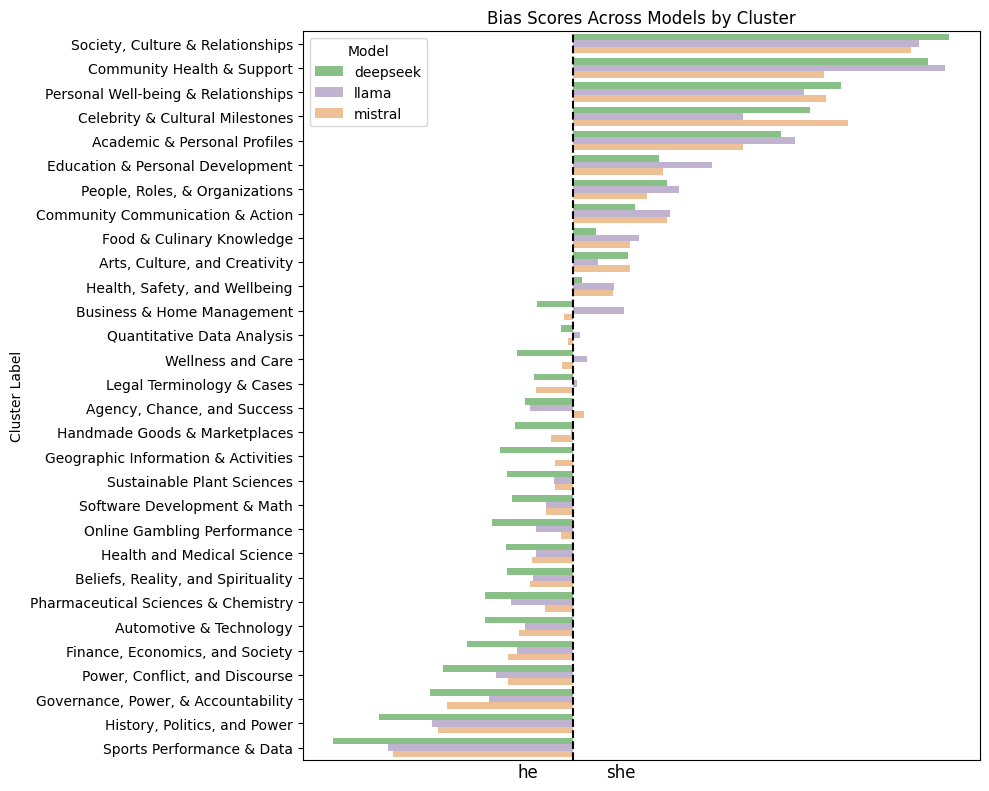

In [ ]:
plot_all_model_biases(bias)

In [ ]:
def plot_all_model_biases_new(model_divergences):
    combined_list = []
    for model_name, model_divergence in model_divergences.items():
        df = model_divergence.copy()
        df['Model Divergence'] *= -1
        df['Cluster'] = df.index.map(cluster_dict).fillna(-1).astype(int)
        model_filtered = df[['Cluster', 'Model Divergence']].groupby('Cluster').mean().reset_index()
        model_filtered['Cluster Label'] = model_filtered['Cluster'].map(cluster_labels_dict)
        model_filtered['Set'] = model_filtered['Model Divergence'].apply(lambda x: "she" if x >= 0 else "he")
        model_filtered.sort_values(by='Model Divergence', inplace=True)
        model_filtered['Model'] = model_name
        combined_list.append(model_filtered)
    combined_df = pd.concat(combined_list, ignore_index=True)
    cluster_order = combined_df.groupby("Cluster Label")["Model Divergence"]\
                                  .mean().sort_values(ascending=False).index
    combined_df["Cluster Label"] = pd.Categorical(combined_df["Cluster Label"],
                                                  categories=cluster_order,
                                                  ordered=True)
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    sns.barplot(data=combined_df, y="Cluster Label", x="Model Divergence",
                hue="Model", palette="Accent", dodge=True, ax=ax)
    # Remove extra x-margin so that ax.get_xlim() reflects the exact data range.
    ax.axvline(0, color="black", linestyle="--", zorder=1)
    x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
    ax.text(+ 0.05*x_range, 30, "she", ha='left', va='center', fontsize=12, color='black')
    ax.text(- 0.05*x_range, 30, "he", ha='right', va='center', fontsize=12, color='black')

    # Show x-axis with bias scores - this is the only change
    ax.xaxis.set_visible(True)

    ax.set_title("Bias Scores Across Models by Cluster")
    ax.set_xlabel("Bias Score")
    ax.set_ylabel("Cluster Label")
    plt.tight_layout()
    plt.show()

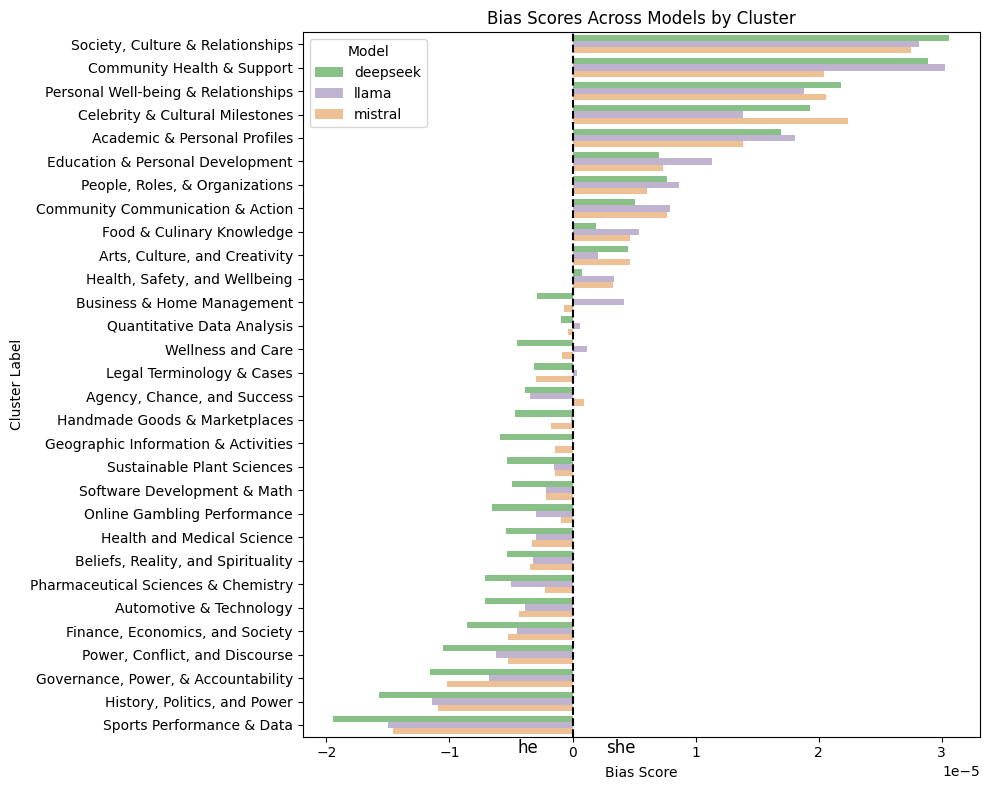

In [ ]:
plot_all_model_biases_new(bias)

In [ ]:
def plot_cluster_biases(model_divergence, model_name):
    model_divergence = model_divergence.copy()
    model_divergence['Model Divergence'] *= - 1
    model_divergence['Cluster'] = model_divergence.index.map(cluster_dict).fillna(-1).astype(int)
    model_filtered = model_divergence[['Cluster', 'Model Divergence']].groupby('Cluster').mean().reset_index()
    model_filtered['Cluster Label'] = model_filtered['Cluster'].map(cluster_labels_dict)
    model_filtered['Set'] = model_filtered['Model Divergence'].apply(lambda x: "she" if x >= 0 else "he")
    model_filtered.sort_values(by='Model Divergence', inplace=True)

    plt.figure(figsize=(10, 8))
    sns.barplot(data=model_filtered, y="Cluster Label", x="Model Divergence", palette="coolwarm", hue='Set', width=0.7)
    plt.axvline(0, color='black', linestyle='--')
    plt.title(f"{model_name} - Bias Scores for Clusters ", fontsize=14)
    plt.xticks([])
    plt.xlabel("Bias Score")
    plt.ylabel("Cluster Label")
    plt.tight_layout()
    plt.show()

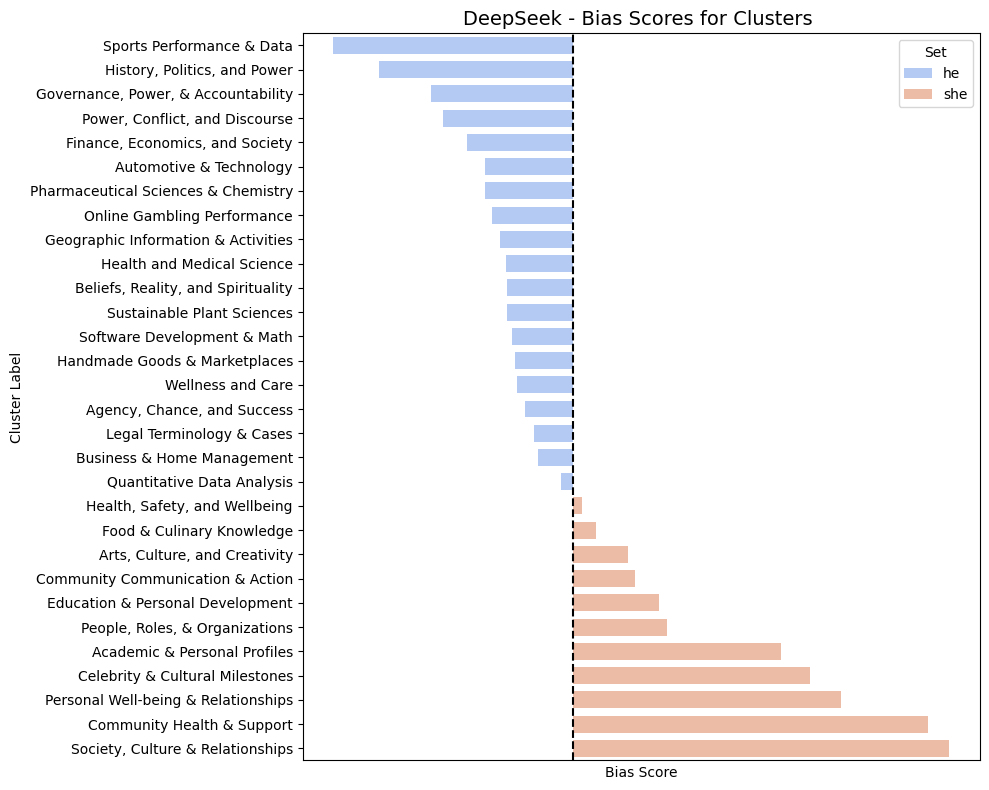

In [ ]:
plot_cluster_biases(bias['deepseek'], "DeepSeek")

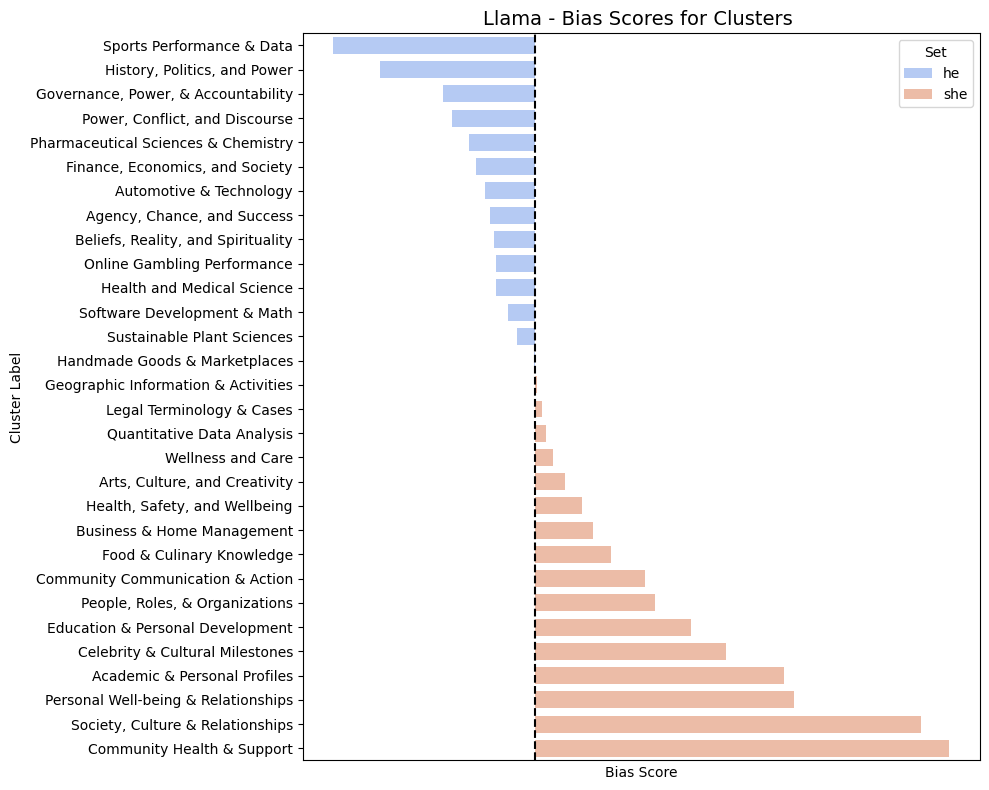

In [ ]:
plot_cluster_biases(bias['llama'], "Llama")

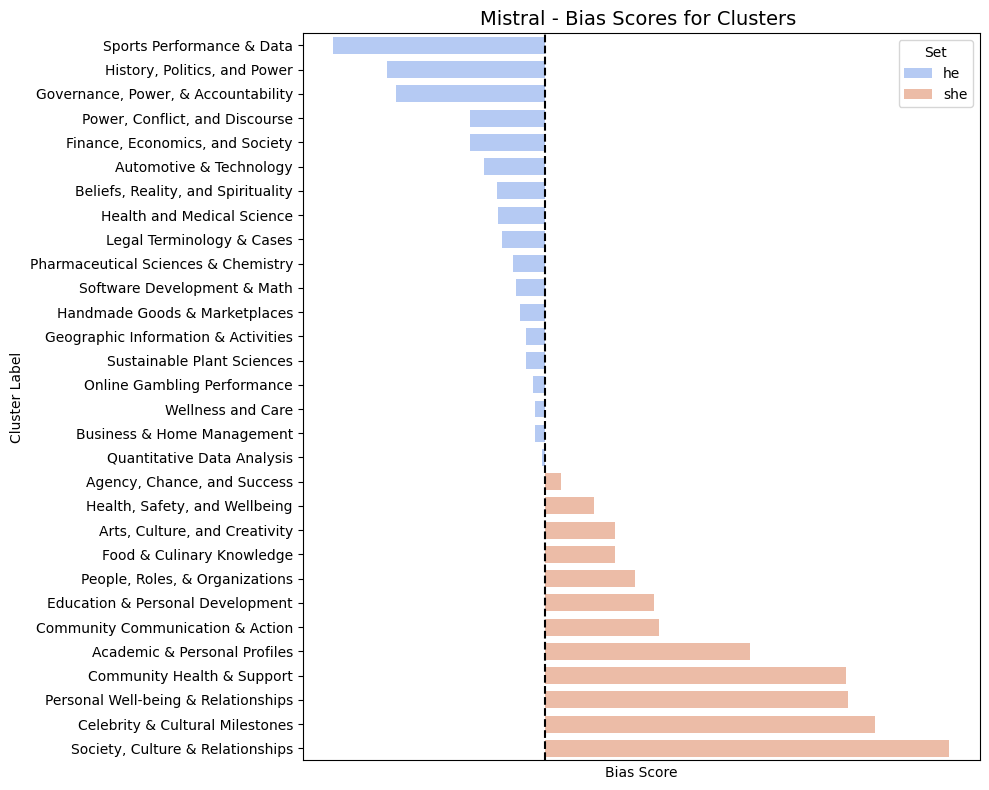

In [ ]:
plot_cluster_biases(bias['mistral'], "Mistral")